In [ ]:
!pip install timm

In [ ]:
!pip uninstall opencv-python

In [ ]:
!pip uninstall opencv-contrib-python

In [ ]:
!pip install opencv-contrib-python==4.5.5.62

In [ ]:
!pip install torch_optimizer

In [ ]:
!pip install mediapipe

In [ ]:
import os
import io
import zipfile
import shutil 
from pathlib import Path

import numpy as np 
import pandas as pd
import random

from tqdm import tqdm
import time
import copy

import cv2
from PIL import Image
import mediapipe as mp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer as optimzr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torchsummary import summary

import albumentations as A
import albumentations.pytorch as AP
from albumentations import (Compose)

import timm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ====================================================
# CFG - класс с параметрами
# ====================================================
class CFG:
    num_workers=2
    model_name='mobilenetv3_large_100'
    size=48
    scheduler='StepLR'
    epochs=30
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=32
    seed=42

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # Фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # Фиксируем заполнения хешей
    np.random.seed(seed) # Фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # Фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # Фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # Выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # Фиксируем алгоритм вычисления сверток

In [ ]:
# ==============================================================
# ImageFolderWithPaths - класс для создания путей до изображения
# ==============================================================
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
# Функция для распаковки zip-архива
def unzip_data(zip_file, destination_dir):
    print('Data extraction started...', end='')
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print('done.')
    print(f'Files unzipped to \'{destination_dir}\'\n')

In [ ]:
# Функция сортировки изображений на train и valid
def make_train_valid_data():
    
    print('Copy pictures to Train and Valid groups started...', end='')
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        src_dir = os.path.join(data_root, 'train', class_name)
        files = os.listdir(src_dir)
        files = list(filter(lambda x: x.endswith('.png'), files)) + list(filter(lambda x: x.endswith('.PNG'), files))
        
        for i, file_name in enumerate(files):
            if i % 11 != 0:
                dst_dir = os.path.join(train_dir, class_name) 
            else:
                dst_dir = os.path.join(valid_dir, class_name)
            shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))
    print('done.')

    # Отчет о том, правильно ли размещаются новые изображения
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            dst_dir = os.path.join(dir_name, class_name)
            files = os.listdir(dst_dir)
            files = list(filter(lambda x: x.endswith('.png'), files)) + list(filter(lambda x: x.endswith('.PNG'), files))
            print(f'{len(files)} pictures copied to \'{dst_dir}\'')
    print()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
train_dir = 'train'
valid_dir = 'valid'

data_root = '/content/ck48/'
unzip_data(zip_file='/content/drive/MyDrive/ck48.zip', destination_dir='/content/ck48/train/')

Data extraction started...done.
Files unzipped to '/content/ck48/train/'



In [ ]:
# Создаем train и valid датасеты
make_train_valid_data()

Copy pictures to Train and Valid groups started...done.
122 pictures copied to 'train/anger'
49 pictures copied to 'train/contempt'
160 pictures copied to 'train/disgust'
68 pictures copied to 'train/fear'
188 pictures copied to 'train/happy'
76 pictures copied to 'train/sadness'
226 pictures copied to 'train/surprise'
13 pictures copied to 'valid/anger'
5 pictures copied to 'valid/contempt'
17 pictures copied to 'valid/disgust'
7 pictures copied to 'valid/fear'
19 pictures copied to 'valid/happy'
8 pictures copied to 'valid/sadness'
23 pictures copied to 'valid/surprise'



In [ ]:
# ====================================================
# MakeDataset - класс для создания датасета
# ====================================================
class MakeDataset(torch.utils.data.Dataset):
    def __init__(self, files, transform=None):
        super().__init__()
        self.files = files           
        self.labels = [path.parent.name for path in self.files]
        self.len_ = len(self.files)
        self.transform = transform
        
    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        image = cv2.imread(f'{self.files[index]}')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
          augmented = self.transform(image=image)
          image = augmented['image']
        
        label = self.labels[index]
        if label == 'anger':
          y = 0
        if label == 'contempt':
          y = 1
        if label == 'disgust':
          y = 2
        if label == 'fear':
          y = 3
        if label == 'happy':
          y = 4
        if label == 'sadness':
          y = 5
        if label == 'surprise':
          y = 6
        return image, y

In [ ]:
def get_transforms(*, data):
   
    if data == 'train':
        return Compose([
            A.Resize(48, 48),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            AP.ToTensorV2()])

    elif data == 'valid':
        return Compose([
            A.Resize(48, 48),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            AP.ToTensorV2()])

In [ ]:
TRAIN_DIR = Path('/content/train')
VAL_DIR = Path('/content/valid')

train_files = sorted(list(TRAIN_DIR.rglob('*.png'))) + sorted(list(TRAIN_DIR.rglob('*.PNG')))
val_files = sorted(list(VAL_DIR.rglob('*.png'))) + sorted(list(VAL_DIR.rglob('*.PNG')))

In [ ]:
train_dataset = MakeDataset(train_files, transform=get_transforms(data='train'))
val_dataset = MakeDataset(val_files, transform=get_transforms(data='valid'))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, 
                              batch_size=CFG.batch_size**2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

print('Train and Valid datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_loader), len(train_dataset)))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_loader), len(val_dataset)))

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train          27       889
Valid           1        92


In [ ]:
def train_val_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    
    best_acc = 0.

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="\n")
        for phase in ['train', 'val']:
            if phase == 'train': # Если фаза == train 
                dataloader = train_loader # Берем train_dataset
                scheduler.step() # Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: # Если фаза == val
                dataloader = valid_loader # Берем valid_dataset 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): # Если фаза train, то активируем все градиенты
                    float_inputs = torch.tensor(inputs, dtype=torch.float)
                    preds = model(float_inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) # Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс, берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() # Считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  # Считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) # Считаем Loss на кол-во бачей в эпохе            
               
            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc), end="\n")

            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
              torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

In [ ]:
class MyMobileV3Net(torch.nn.Module):
    def __init__(self, model_name='mobilenetv3_large_100', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)            
        
        # Добавляем полносвязанную голову
        self.model.classifier = torch.nn.Sequential(
          torch.nn.Linear(1280, 512),
          torch.nn.ReLU(),
          torch.nn.Linear(512, 7),
        )         

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MyMobileV3Net(CFG.model_name, pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем Loss функцию
# В данном случае - это кросс-энтропия 
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска AdamP
optimizer = optimzr.AdamP(model.parameters(), lr=CFG.lr) 

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv3_large_100_ra-f55367f5.pth


In [ ]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

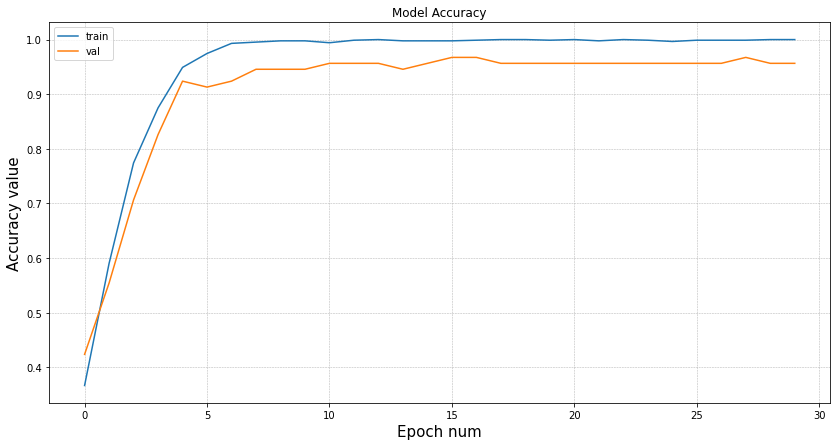

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

# Инференс

In [ ]:
# Загружаем предварительно сохраненную модель
device = torch.device('cpu')
model = MyMobileV3Net(CFG.model_name, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mobilenetv3_large_100_ck48.pth', map_location=torch.device('cpu')))
model.eval()
model.to(device)

In [ ]:
pred_transforms = Compose([
    A.Resize(48, 48),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    AP.ToTensorV2()])

In [ ]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

In [ ]:
def detection_preprocessing(image, h_max=360):
    h, w, _ = image.shape
    if h > h_max:
        ratio = h_max / h
        w_ = int(w * ratio)
        image = cv2.resize(image, (w_,h_max))
    return image

In [ ]:
def inference(image):
    H, W, _ = image.shape
    
    #rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image)

    if results.detections:
        pos = []
        faces = []
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            # mp_drawing.draw_detection(image, detection)

            x = int(box.xmin * W)
            y = int(box.ymin * H)
            w = int(box.width * W)
            h = int(box.height * H)

            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(x + w, W)
            y2 = min(y + h, H)

            face = image[y1:y2,x1:x2]
            #face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
            faces.append(face)
            pos.append((x1, y1, x2, y2))
            break
    
        #x = recognition_preprocessing(faces)
        image_tensor = pred_transforms(image=face)["image"].unsqueeze(0)
        image_tensor = image_tensor.clone().detach()
        input = image_tensor.to(device)
        outputs = model(input)
        _, preds = torch.max(outputs, 1)

        for i in range(len(faces)):
            cv2.rectangle(image, (pos[i][0],pos[i][1]),
                            (pos[i][2],pos[i][3]), (0, 255, 0), lineType=cv2.LINE_AA)
            
            cv2.rectangle(image, (pos[i][0],pos[i][1]-20),
                            (pos[i][2]+20,pos[i][1]), (0, 0, 255), lineType=cv2.LINE_AA)
            
            cv2.putText(image, f'{class_names[int(preds.cpu().numpy())]}', (pos[i][0],pos[i][1]-5),
                            0, 0.6, 2, lineType=cv2.LINE_AA)
    
    print(f'{class_names[int(preds.cpu().numpy())]}')
    plt.imshow(image)

anger


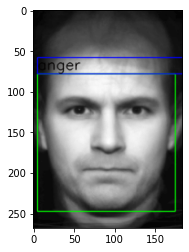

In [ ]:
image = cv2.imread('/content/drive/MyDrive/facial-expressions1.png')
inference(image)

surprise


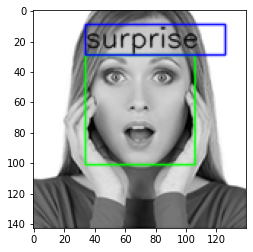

In [ ]:
image = cv2.imread('/content/drive/MyDrive/emotion-triggers-2.png')
inference(image)

happy


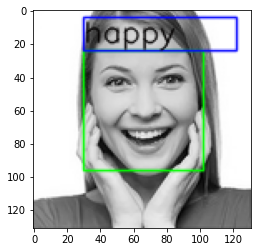

In [ ]:
image = cv2.imread('/content/drive/MyDrive/emotion-triggers-3.png')
inference(image)